## 4 Soil Mositure Analysis
Goal is to take processed Sentinel-1 data and produce a usable visual of soil moisture, but limited due to lack of time series analysis and improved accuracy from machine learning models

Process:
* Extract Sentinel-1 backscatter values from preprocessed product
* Align Sentinel-1 and SMAP data coordinates after reading SMAP soil moisture data
* Interpolate Sentinel-1 backscatter to the SMAP grid to account for different resolutions
* Train regression model to estimate soil moisture with backscatter as the predictor and SMAP soil moisture data as output
* Visualize regression model and soil moisture

Resources:
* Previous WiCSE Shadowing work in emperical_approach.py
* https://ieeexplore.ieee.org/document/10652236
* https://ieeexplore.ieee.org/abstract/document/8444430
* https://www.sciencedirect.com/science/article/abs/pii/S0273117722002058
* https://earthaccess.readthedocs.io/en/latest/user-reference/api/api/
* https://www.mdpi.com/2072-4292/12/8/1242
* https://scitools.org.uk/cartopy/docs/v0.15/matplotlib/intro.html
* https://scipy.org/
* https://scikit-learn.org/stable/
* https://numpy.org/doc/2.1/reference/generated/numpy.save.html

In [3]:
# can replace these imports using requirements. txt and the following command
#%pip install -r requirements.txt

import earthaccess
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## 4.1 Retrieving SMAP data

The SMAP data set's online interface is difficult to navigate and search through. earthaccess is a better solution. Users must make an account.

In [4]:
# https://earthaccess.readthedocs.io/en/latest/howto/onprem/

auth = earthaccess.login()

# bounding box coordinates retrieved in sar processing, replace with your own sentinel1 information

# a tuple representing spatial bounds in the form (lower_left_lon, lower_left_lat, upper_right_lon, upper_right_lat)
coordinates = np.load('coordinates.npy', allow_pickle=True)

bottom_left = coordinates[0]
top_right = coordinates[1]

bounding_box = (
    bottom_left[0][1],  # lower left longitude (from bottom left lon)
    bottom_left[0][0],  # lower left latitude (from bottom left lat)
    top_right[0][1], # upper right longitude (from top right lon)
    top_right[0][0]   # upper right latitude (from top right lat)
)

'''bounding_box = (
    -81.8378841159868,  # lower left longitude (from bottom left lon)
    24.70653891369735,  # lower left latitude (from bottom left lat)
    -79.63403342237105, # upper right longitude (from top right lon)
    26.63335452928809   # upper right latitude (from top right lat)
)'''

# from sentinel1 data, replace with your own sentinel1 information
# a tuple representing temporal bounds in the form (date_from, date_to)
s1_date = "2025-04-01"

results = earthaccess.search_data(
    short_name="SPL3SMP",   # SMAP Level 3 Soil Moisture Product
    temporal=(s1_date, s1_date),   
    bounding_box=bounding_box,  
    cloud_hosted=True,
    count = 1
)

downloaded_files = earthaccess.download(
    results,
    local_path='.',
)


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

## 4.2 Read SMAP files

In [5]:
file = h5py.File(downloaded_files[0], 'r')

def print_hdf5(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(name)

file.visititems(print_hdf5)

soil_moisture = file['Soil_Moisture_Retrieval_Data_AM/soil_moisture'][:]
latitude = file['Soil_Moisture_Retrieval_Data_AM/latitude'][:]
longitude = file['Soil_Moisture_Retrieval_Data_AM/longitude'][:]

# SMAP fills data even if its bounded, so we need to mask the fill values

valid_mask = (soil_moisture != -9999.0) & (latitude != -9999.0) & (longitude != -9999.0)

og_soil_moisture = soil_moisture
og_latitude = latitude
og_longitude = longitude

latitude = latitude[valid_mask]
longitude = longitude[valid_mask]
soil_moisture  = soil_moisture[valid_mask]

Soil_Moisture_Retrieval_Data_AM/EASE_column_index
Soil_Moisture_Retrieval_Data_AM/EASE_row_index
Soil_Moisture_Retrieval_Data_AM/albedo
Soil_Moisture_Retrieval_Data_AM/albedo_scah
Soil_Moisture_Retrieval_Data_AM/albedo_scav
Soil_Moisture_Retrieval_Data_AM/boresight_incidence
Soil_Moisture_Retrieval_Data_AM/bulk_density
Soil_Moisture_Retrieval_Data_AM/clay_fraction
Soil_Moisture_Retrieval_Data_AM/freeze_thaw_fraction
Soil_Moisture_Retrieval_Data_AM/grid_surface_status
Soil_Moisture_Retrieval_Data_AM/landcover_class
Soil_Moisture_Retrieval_Data_AM/landcover_class_fraction
Soil_Moisture_Retrieval_Data_AM/latitude
Soil_Moisture_Retrieval_Data_AM/latitude_centroid
Soil_Moisture_Retrieval_Data_AM/longitude
Soil_Moisture_Retrieval_Data_AM/longitude_centroid
Soil_Moisture_Retrieval_Data_AM/radar_water_body_fraction
Soil_Moisture_Retrieval_Data_AM/retrieval_qual_flag
Soil_Moisture_Retrieval_Data_AM/retrieval_qual_flag_scah
Soil_Moisture_Retrieval_Data_AM/retrieval_qual_flag_scav
Soil_Moisture_R

## 4.3 Prepare data for regression model

Partly done in sar_processing_snappy.ipynb file because sentinel-1 data is from the terrain_correction product, and it was easier to save the np arrays to use in another notebook. This block of code interpolates the SMAP and Sentinel-1 data to account for different resolutions, ensures the data have equal number of coordinates, and filters the invalid data out.


In [6]:
# load sentinel1 data, completed in sar_processing_snappy.ipynb
s1_longs = np.load('s1_longs.npy')
s1_lats = np.load('s1_lats.npy')
s1_backscatter_db = np.load('s1_backscatter_db.npy')

# interpolate SMAP soil moisture to sentinel-1 coordinates, necessary because they have very different resolutions
smap_coords = np.vstack((longitude.flatten(), latitude.flatten())).T
smap_values = soil_moisture.flatten()
smap_interp = griddata(smap_coords, smap_values, (s1_longs, s1_lats), method='linear')

# ensure both arrays have same number of coordinates
og_s1_backscatter_db = s1_backscatter_db
if s1_backscatter_db.shape != smap_interp.shape:
    min_len = min(len(s1_backscatter_db), len(smap_interp))
    s1_backscatter_db = s1_backscatter_db[:min_len]
    smap_interp = smap_interp[:min_len]

# filter invalid entries
valid_mask = ~np.isnan(smap_interp) & ~np.isnan(s1_backscatter_db)
X = s1_backscatter_db[valid_mask].reshape(-1, 1)
y = smap_interp[valid_mask]

## 4.4 Train Regression Model
Limited due to lack of data, but the idea is there. X is the backscatter values scaled to to decibels as standard method suggest and y is the interpolated smap data.

R² Score: 0.237
Root Mean Squared Error: 0.0004
Regression Coefficient: -0.00009
Intercept: 0.37068


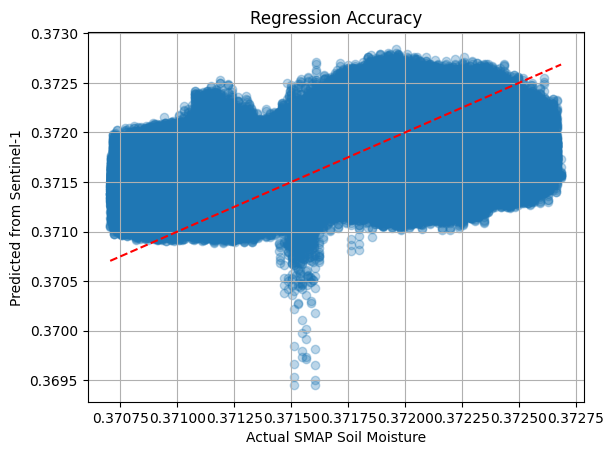

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

from sklearn.metrics import r2_score, mean_squared_error

print(f"R² Score: {r2_score(y, y_pred):.3f}")
# rmse (root mean squared error) used because same units
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Regression Coefficient: {model.coef_[0]:.5f}")
print(f"Intercept: {model.intercept_:.5f}")

import matplotlib.pyplot as plt

plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual SMAP Soil Moisture")
plt.ylabel("Predicted from Sentinel-1")
plt.title("Regression Accuracy")
plt.grid(True)
plt.show()


## 4.5 Map the soil moisture estimation

### Showing where the soil moisture prediction is occurring within the shape of the sentinel-1 data. This plot limits the soil moisture prediction to only the available SMAP data (SMAP data was not existent for all of the sentinel-1 area)

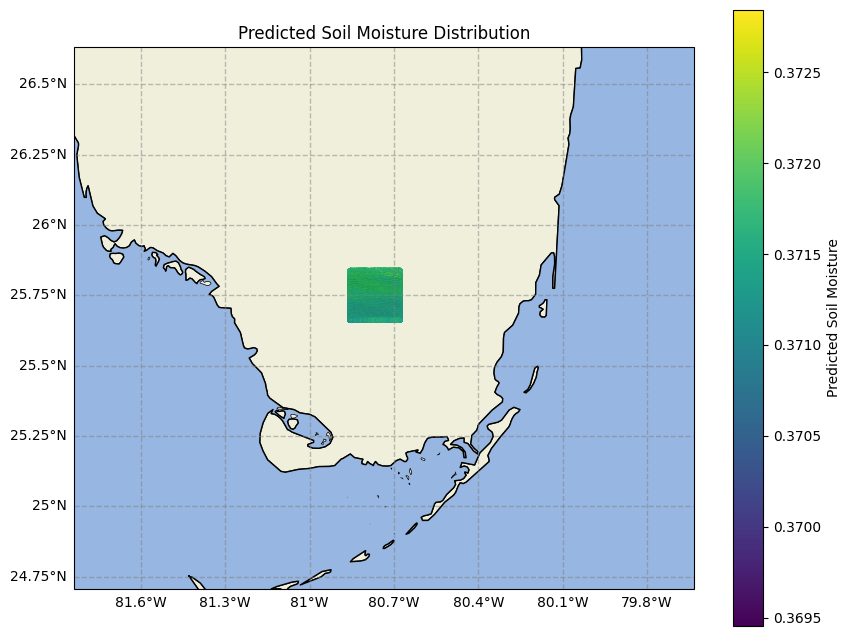

In [8]:
# regression model cannot work with nan values
reg_mask = (~np.isnan(smap_interp)) & (~np.isnan(s1_backscatter_db))

# prepare input to model
X_pred = s1_backscatter_db[reg_mask].reshape(-1, 1)

# coordinates
pred_lons = s1_longs[reg_mask]
pred_lats = s1_lats[reg_mask]

# use regression model to predict soil moisture
predicted_sm = model.predict(X_pred)

# plot with bounding box
min_lon, min_lat, max_lon, max_lat = bounding_box

fig, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# show longitude and latitude
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False

# add context
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)

# scatter only regression points
sc = ax.scatter(
    pred_lons, pred_lats,
    c=predicted_sm,
    cmap='viridis',
    s=5,
    transform=ccrs.PlateCarree()
)

plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.05, label='Predicted Soil Moisture')
ax.set_title('Predicted Soil Moisture Distribution')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()


### Showing the soil moisture predictions for only where there is SMAP data. Same as previous plot except not on the sentinel-1 data shape

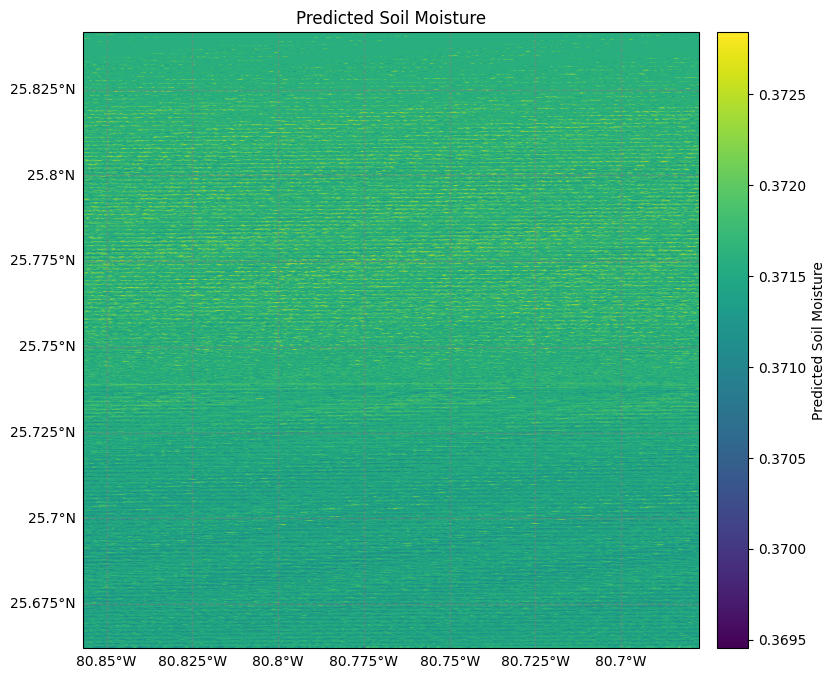

In [9]:
# fill nans in the SAR backscatter array so the model can predict everywhere
mean_back = np.nanmean(s1_backscatter_db)
filled_back = np.where(np.isnan(s1_backscatter_db), mean_back, s1_backscatter_db)

# ensure no nans
full_mask = ~np.isnan(filled_back)

# prepare input to regression
X_full = filled_back[full_mask].reshape(-1, 1)

# coordinates
lon_full = s1_longs[full_mask]
lat_full = s1_lats[full_mask]

# regresion model prediction
pred_full = model.predict(X_full)

fig, ax = plt.subplots(
    figsize=(12, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

ax.set_extent([lon_full.min(), lon_full.max(), lat_full.min(), lat_full.max()], crs=ccrs.PlateCarree())

# show longitude, latitude
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False

# add context
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.coastlines()

# scatter predictions
sc = ax.scatter(
    lon_full, lat_full,
    c=pred_full,
    cmap='viridis',
    s=2,
    transform=ccrs.PlateCarree()
)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Predicted Soil Moisture')
ax.set_title('Predicted Soil Moisture')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()


### Plotting the difference map to visualize the error

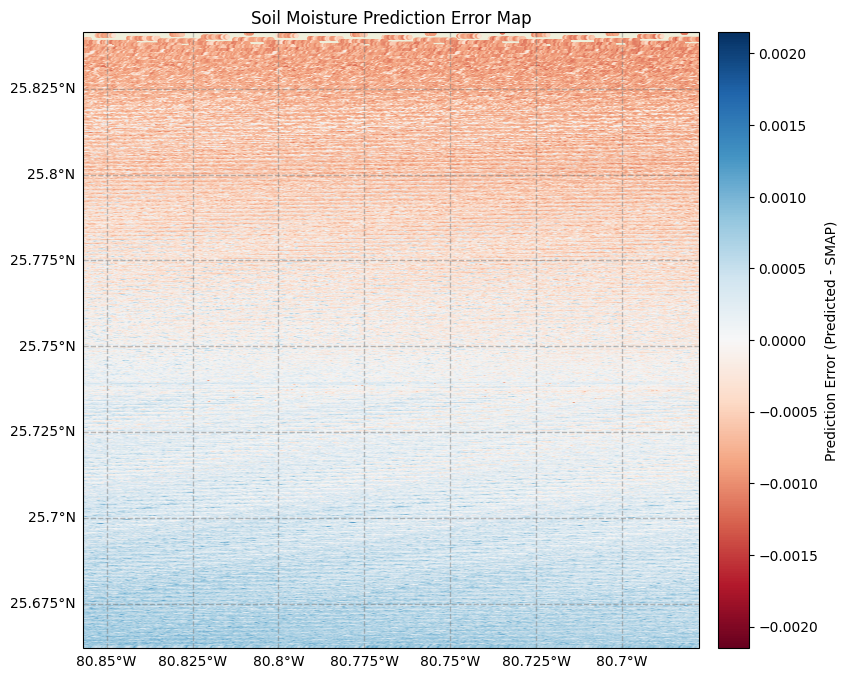

In [10]:
# mask so lenghts are equal
valid_mask = ~np.isnan(smap_interp) & ~np.isnan(s1_backscatter_db)
plot_lons = s1_longs[valid_mask]
plot_lats = s1_lats[valid_mask]
truth_sm = smap_interp[valid_mask]
pred_sm = model.predict(s1_backscatter_db[valid_mask].reshape(-1, 1))

# calculation
diff = pred_sm - truth_sm  

# plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([plot_lons.min(), plot_lons.max(), plot_lats.min(), plot_lats.max()], crs=ccrs.PlateCarree())

# longitude, latitude
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# add context
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.coastlines()

sc = ax.scatter(
    plot_lons, plot_lats,
    c=diff,
    cmap='RdBu',
    s=5,
    vmin=-np.max(np.abs(diff)),  
    vmax=np.max(np.abs(diff)),
    transform=ccrs.PlateCarree()
)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Prediction Error (Predicted - SMAP)')
ax.set_title('Soil Moisture Prediction Error Map')
plt.show()
